# 🤖 Modelos de Machine Learning Avanzados
## Trabajo Final - Inteligencia de Negocios 2025

**Maestría en Economía Aplicada - UBA**  
**Dataset:** Inmuebles procesado y filtrado

### Objetivos del Notebook
1. **Implementar Random Forest** con optimización de hiperparámetros
2. **Desarrollar XGBoost** con gradient boosting avanzado
3. **Crear Neural Networks** para capturar relaciones complejas
4. **Analizar feature importance** y patrones no lineales
5. **Superar baseline** de RMSE $42,960 (modelos tradicionales)

---

## 📦 Configuración Inicial

In [8]:
# Importación de librerías principales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import yaml  # Para guardar resultados en YAML
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn core
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Modelos de ML
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb

# Configuración de visualizaciones
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
sns.set_palette("husl")

print("✅ Configuración completada")
print(f"📦 Librerías cargadas: pandas, numpy, sklearn, xgboost")
print(f"💾 PyYAML cargado para guardado de resultados en YAML")
print(f"🎯 Objetivo: Superar RMSE baseline de $42,960")

✅ Configuración completada
📦 Librerías cargadas: pandas, numpy, sklearn, xgboost
💾 PyYAML cargado para guardado de resultados en YAML
🎯 Objetivo: Superar RMSE baseline de $42,960


In [9]:
# 🔧 FUNCIÓN UTILITARIA PARA GUARDADO YAML CENTRALIZADO
def save_result_to_yaml(resultado, yaml_path='resultados_modelos_ml.yaml'):
    """
    Guarda resultados de forma incremental en archivo YAML.
    Evita duplicados y mantiene historial acumulativo.
    
    Parameters:
    -----------
    resultado : dict
        Diccionario con los resultados a guardar
    yaml_path : str
        Ruta del archivo YAML
    """
    import yaml
    import copy
    
    def convert_tuples_to_lists(obj):
        """Convierte tuplas a listas para compatibilidad YAML"""
        if isinstance(obj, dict):
            return {k: convert_tuples_to_lists(v) for k, v in obj.items()}
        elif isinstance(obj, tuple):
            return list(obj)
        elif isinstance(obj, list):
            return [convert_tuples_to_lists(i) for i in obj]
        else:
            return obj
    
    # Leer archivo existente o crear lista vacía
    try:
        with open(yaml_path, 'r', encoding='utf-8') as f:
            data = yaml.safe_load(f) or []
    except FileNotFoundError:
        data = []
    
    # Asegurar que data es una lista
    if not isinstance(data, list):
        data = [data]
    
    # Convertir tuplas a listas para compatibilidad YAML
    resultado_clean = convert_tuples_to_lists(copy.deepcopy(resultado))
    
    # Identificar tipo de entrada y evitar duplicados
    if 'modelo' in resultado_clean:
        # Es un modelo individual - eliminar versión anterior del mismo modelo
        modelo_nombre = resultado_clean['modelo']
        data = [d for d in data if d.get('modelo') != modelo_nombre]
        print(f"💾 Guardando modelo: {modelo_nombre}")
    elif 'comparacion_ml' in resultado_clean:
        # Es un resumen comparativo ML - eliminar resumen anterior
        data = [d for d in data if 'comparacion_ml' not in d]
        print(f"💾 Guardando resumen comparativo ML")
    else:
        # Otro tipo de entrada
        print(f"💾 Guardando entrada personalizada")
    
    # Agregar nuevo resultado
    data.append(resultado_clean)
    
    # Guardar archivo con formato legible
    with open(yaml_path, 'w', encoding='utf-8') as f:
        yaml.dump(data, f, allow_unicode=True, sort_keys=False, indent=2)
    
    print(f"✅ Resultados guardados en {yaml_path}")
    print(f"📊 Total de entradas en archivo: {len(data)}")
    return data

print("🔧 Función de guardado YAML centralizada creada")
print("✅ Sistema de guardado incremental configurado para modelos ML")

🔧 Función de guardado YAML centralizada creada
✅ Sistema de guardado incremental configurado para modelos ML


## 🔍 1. Carga y Preparación de Datos

In [10]:
# Cargar dataset procesado (mismo que modelos tradicionales)
df = pd.read_csv('train_bi_2025_filtered.csv')

print("📋 DATASET CARGADO PARA ML AVANZADO")
print("=" * 45)
print(f"Dimensiones: {df.shape[0]:,} filas × {df.shape[1]} columnas")
print(f"Tamaño en memoria: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# Verificar distribución del target
print(f"\n💰 VARIABLE OBJETIVO (PRICE):")
print(f"Promedio: ${df['price'].mean():,.0f}")
print(f"Mediana:  ${df['price'].median():,.0f}")
print(f"Std Dev:  ${df['price'].std():,.0f}")
print(f"Rango:    ${df['price'].min():,.0f} - ${df['price'].max():,.0f}")

# Verificar ausencia de valores nulos críticos
null_counts = df.isnull().sum().sum()
print(f"\n🔍 CALIDAD DE DATOS:")
print(f"Total valores nulos: {null_counts}")
if null_counts == 0:
    print("✅ Dataset limpio - Sin valores nulos")
else:
    print("⚠️ Revisar tratamiento de nulos")

📋 DATASET CARGADO PARA ML AVANZADO
Dimensiones: 311,660 filas × 15 columnas
Tamaño en memoria: 377.8 MB

💰 VARIABLE OBJETIVO (PRICE):
Promedio: $160,807
Mediana:  $139,100
Std Dev:  $83,071
Rango:    $2,170 - $488,274

🔍 CALIDAD DE DATOS:
Total valores nulos: 0
✅ Dataset limpio - Sin valores nulos


### 1.1 Preparación de Features (Consistente con Modelos Tradicionales)

In [11]:
def prepare_features_ml(df):
    """
    Prepara las features para ML avanzado - IDÉNTICA a modelos tradicionales
    para mantener consistencia en la comparación.
    
    NOTA: Excluye 'description' para evitar problemas de memoria
    con demasiadas variables dummy.
    
    Returns:
    --------
    X : DataFrame
        Features preparadas para modelado
    y : Series
        Variable objetivo
    feature_info : dict
        Información sobre las features procesadas
    """
    # Excluir coordenadas geográficas, target y description (consistente con notebook 02)
    exclude_cols = ['lat', 'lon', 'price', 'description']
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    
    # Separar features y target
    X = df[feature_cols].copy()
    y = df['price'].copy()
    
    # Identificar tipos de variables
    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    
    print(f"🔢 Variables numéricas ({len(numerical_cols)}): {numerical_cols}")
    print(f"🏷️ Variables categóricas ({len(categorical_cols)}): {categorical_cols}")
    
    # Aplicar encoding one-hot a variables categóricas
    if len(categorical_cols) > 0:
        X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
        print(f"✅ Variables categóricas convertidas a {X_encoded.shape[1] - len(numerical_cols)} variables dummy")
    else:
        X_encoded = X.copy()
        print("ℹ️ No hay variables categóricas para convertir")
    
    # Información del procesamiento
    feature_info = {
        'original_features': len(feature_cols),
        'encoded_features': X_encoded.shape[1],
        'numerical_vars': len(numerical_cols),
        'categorical_vars': len(categorical_cols),
        'dummy_vars_created': X_encoded.shape[1] - len(numerical_cols)
    }
    
    return X_encoded, y, feature_info

# Preparar datos con la misma función que modelos tradicionales
X, y, feature_info = prepare_features_ml(df)

print("\n🔧 PREPARACIÓN DE FEATURES COMPLETADA")
print("=" * 50)
print(f"Features originales:      {feature_info['original_features']}")
print(f"Features codificadas:     {feature_info['encoded_features']}")
print(f"Variables numéricas:      {feature_info['numerical_vars']}")
print(f"Variables categóricas:    {feature_info['categorical_vars']}")
print(f"Variables dummy creadas:  {feature_info['dummy_vars_created']}")

print(f"\n📊 DATASET FINAL PARA ML:")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"✅ Preparación idéntica a modelos tradicionales para comparación justa")

🔢 Variables numéricas (8): ['rooms', 'bathrooms', 'surface_total', 'surface_covered', 'created_year', 'created_month', 'created_quarter', 'created_weekday']
🏷️ Variables categóricas (3): ['l2', 'l3', 'prop_type']
✅ Variables categóricas convertidas a 85 variables dummy

🔧 PREPARACIÓN DE FEATURES COMPLETADA
Features originales:      11
Features codificadas:     93
Variables numéricas:      8
Variables categóricas:    3
Variables dummy creadas:  85

📊 DATASET FINAL PARA ML:
X shape: (311660, 93)
y shape: (311660,)
✅ Preparación idéntica a modelos tradicionales para comparación justa


### 1.2 División Train/Test y Estandarización

In [12]:
# División IDÉNTICA a modelos tradicionales (mismo random_state)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=None
)

print("📊 DIVISIÓN DE DATOS (Idéntica a Notebook 02)")
print("=" * 50)
print(f"Entrenamiento: {X_train.shape[0]:,} muestras ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Prueba:        {X_test.shape[0]:,} muestras ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"Features:      {X_train.shape[1]} variables")

# Estandarización para modelos que lo requieren (Neural Networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✅ ESTANDARIZACIÓN COMPLETADA:")
print(f"Media features escaladas:    {X_train_scaled.mean():.6f}")
print(f"Desv. std features escaladas: {X_train_scaled.std():.6f}")

# Verificar distribución del target (debe ser idéntica a notebook 02)
print(f"\n💰 DISTRIBUCIÓN DEL TARGET:")
print(f"Train - Promedio: ${y_train.mean():,.0f}, Std: ${y_train.std():,.0f}")
print(f"Test  - Promedio: ${y_test.mean():,.0f}, Std: ${y_test.std():,.0f}")

# Baseline a superar (de modelos tradicionales)
BASELINE_RMSE = 42960  # LASSO modelo de notebook 02
BASELINE_R2 = 0.7284

print(f"\n🎯 BASELINE A SUPERAR:")
print(f"RMSE Baseline: ${BASELINE_RMSE:,}")
print(f"R² Baseline:   {BASELINE_R2:.4f}")
print(f"📈 Meta: Reducir RMSE < ${BASELINE_RMSE:,} y aumentar R² > {BASELINE_R2:.4f}")

📊 DIVISIÓN DE DATOS (Idéntica a Notebook 02)
Entrenamiento: 249,328 muestras (80.0%)
Prueba:        62,332 muestras (20.0%)
Features:      93 variables

✅ ESTANDARIZACIÓN COMPLETADA:
Media features escaladas:    0.000000
Desv. std features escaladas: 1.000000

💰 DISTRIBUCIÓN DEL TARGET:
Train - Promedio: $160,893, Std: $83,226
Test  - Promedio: $160,460, Std: $82,447

🎯 BASELINE A SUPERAR:
RMSE Baseline: $42,960
R² Baseline:   0.7284
📈 Meta: Reducir RMSE < $42,960 y aumentar R² > 0.7284

✅ ESTANDARIZACIÓN COMPLETADA:
Media features escaladas:    0.000000
Desv. std features escaladas: 1.000000

💰 DISTRIBUCIÓN DEL TARGET:
Train - Promedio: $160,893, Std: $83,226
Test  - Promedio: $160,460, Std: $82,447

🎯 BASELINE A SUPERAR:
RMSE Baseline: $42,960
R² Baseline:   0.7284
📈 Meta: Reducir RMSE < $42,960 y aumentar R² > 0.7284


### 1.3 Funciones de Evaluación y Utilidades

In [13]:
def calculate_metrics(y_true, y_pred, set_name=""):
    """Calcula métricas de evaluación para regresión"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    return {
        f'RMSE_{set_name}': rmse,
        f'MAE_{set_name}': mae,
        f'R2_{set_name}': r2
    }

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Evaluación completa de un modelo ML
    
    Returns:
    --------
    dict: Métricas completas del modelo
    """
    # Predicciones
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Métricas
    train_metrics = calculate_metrics(y_train, y_pred_train, "Train")
    test_metrics = calculate_metrics(y_test, y_pred_test, "Test")
    
    # Combinar métricas
    all_metrics = {**train_metrics, **test_metrics}
    all_metrics['Model'] = model_name
    all_metrics['Overfitting_Ratio'] = all_metrics['RMSE_Test'] / all_metrics['RMSE_Train']
    
    # Comparación con baseline
    all_metrics['RMSE_Improvement'] = BASELINE_RMSE - all_metrics['RMSE_Test']
    all_metrics['R2_Improvement'] = all_metrics['R2_Test'] - BASELINE_R2
    all_metrics['Better_than_Baseline'] = all_metrics['RMSE_Test'] < BASELINE_RMSE
    
    return all_metrics, y_pred_train, y_pred_test

def print_model_results(metrics, show_comparison=True):
    """Imprime resultados de manera estandarizada"""
    model_name = metrics['Model']
    
    print(f"📊 RESULTADOS {model_name.upper()}")
    print("=" * 50)
    print(f"RMSE Entrenamiento: ${metrics['RMSE_Train']:,.0f}")
    print(f"RMSE Prueba:        ${metrics['RMSE_Test']:,.0f}")
    print(f"MAE Entrenamiento:  ${metrics['MAE_Train']:,.0f}")
    print(f"MAE Prueba:         ${metrics['MAE_Test']:,.0f}")
    print(f"R² Entrenamiento:   {metrics['R2_Train']:.4f}")
    print(f"R² Prueba:          {metrics['R2_Test']:.4f}")
    print(f"Ratio Overfitting:  {metrics['Overfitting_Ratio']:.3f}")
    
    if show_comparison:
        print(f"\n🎯 COMPARACIÓN CON BASELINE:")
        improvement_rmse = metrics['RMSE_Improvement']
        improvement_r2 = metrics['R2_Improvement']
        
        if improvement_rmse > 0:
            print(f"✅ Mejora RMSE: ${improvement_rmse:,.0f} ({improvement_rmse/BASELINE_RMSE*100:.2f}%)")
        else:
            print(f"❌ Empeora RMSE: ${-improvement_rmse:,.0f} ({-improvement_rmse/BASELINE_RMSE*100:.2f}%)")
            
        if improvement_r2 > 0:
            print(f"✅ Mejora R²: +{improvement_r2:.4f} ({improvement_r2/BASELINE_R2*100:.2f}%)")
        else:
            print(f"❌ Empeora R²: {improvement_r2:.4f} ({improvement_r2/BASELINE_R2*100:.2f}%)")
            
        if metrics['Better_than_Baseline']:
            print(f"🏆 SUPERA EL BASELINE")
        else:
            print(f"⚠️ No supera el baseline")

# Inicializar almacenamiento de resultados
ml_results = {}

print("🛠️ FUNCIONES DE EVALUACIÓN CONFIGURADAS")
print("✅ Métricas estandarizadas listas")
print("✅ Comparación con baseline automatizada")
print("✅ Detección de overfitting incluida")

🛠️ FUNCIONES DE EVALUACIÓN CONFIGURADAS
✅ Métricas estandarizadas listas
✅ Comparación con baseline automatizada
✅ Detección de overfitting incluida


## 🌳 2. Random Forest - Ensemble Learning

### 2.1 Configuración Inicial y Baseline

In [14]:
# Entrenar Random Forest inicial con parámetros básicos
print("🌳 ENTRENANDO RANDOM FOREST INICIAL")
print("=" * 50)

# Configuración inicial conservadora
rf_initial = RandomForestRegressor(
    n_estimators=100,      # Número moderado de árboles
    max_depth=15,          # Profundidad controlada
    min_samples_split=5,   # Mínimo para dividir nodo
    min_samples_leaf=2,    # Mínimo en hoja
    random_state=42,
    n_jobs=-1,             # Usar todos los cores
    verbose=1              # Mostrar progreso
)

print("⏳ Entrenando modelo inicial...")
rf_initial.fit(X_train, y_train)

# Evaluar modelo inicial
rf_initial_metrics, y_pred_train_rf_init, y_pred_test_rf_init = evaluate_model(
    rf_initial, X_train, X_test, y_train, y_test, "Random Forest (Inicial)"
)

print_model_results(rf_initial_metrics)

# Guardar resultados usando función centralizada
rf_initial_resultados = {
    'modelo': 'Random Forest (Inicial)',
    'tipo': 'ml',
    'hiperparametros': {
        'n_estimators': 100,
        'max_depth': 15,
        'min_samples_split': 5,
        'min_samples_leaf': 2,
        'random_state': 42,
        'n_jobs': -1,
        'verbose': 1
    },
    'n_features': X.shape[1],
    'metricas': {
        'train': {
            'RMSE': float(rf_initial_metrics['RMSE_Train']),
            'MAE': float(rf_initial_metrics['MAE_Train']),
            'R2': float(rf_initial_metrics['R2_Train'])
        },
        'test': {
            'RMSE': float(rf_initial_metrics['RMSE_Test']),
            'MAE': float(rf_initial_metrics['MAE_Test']),
            'R2': float(rf_initial_metrics['R2_Test'])
        },
        'overfitting_ratio': float(rf_initial_metrics['Overfitting_Ratio'])
    },
    'notebook': '03_modelos_ml_clean.ipynb'
}

# Usar función centralizada
save_result_to_yaml(rf_initial_resultados)

# Guardar resultados en variable para tabla comparativa
ml_results['RF_Initial'] = rf_initial_metrics

print(f"\n📊 ANÁLISIS INICIAL:")
if rf_initial_metrics['Better_than_Baseline']:
    print("🎉 ¡Random Forest inicial ya supera el baseline!")
else:
    print("📈 Necesita optimización para superar baseline")
    
print(f"Tiempo de entrenamiento: modelo básico completado")

🌳 ENTRENANDO RANDOM FOREST INICIAL
⏳ Entrenando modelo inicial...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   43.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   43.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


📊 RESULTADOS RANDOM FOREST (INICIAL)
RMSE Entrenamiento: $34,655
RMSE Prueba:        $37,576
MAE Entrenamiento:  $24,359
MAE Prueba:         $26,346
R² Entrenamiento:   0.8266
R² Prueba:          0.7923
Ratio Overfitting:  1.084

🎯 COMPARACIÓN CON BASELINE:
✅ Mejora RMSE: $5,384 (12.53%)
✅ Mejora R²: +0.0639 (8.77%)
🏆 SUPERA EL BASELINE
💾 Guardando modelo: Random Forest (Inicial)
✅ Resultados guardados en resultados_modelos_ml.yaml
📊 Total de entradas en archivo: 1

📊 ANÁLISIS INICIAL:
🎉 ¡Random Forest inicial ya supera el baseline!
Tiempo de entrenamiento: modelo básico completado


[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


### 2.2 Optimización de Hiperparámetros

In [15]:
# Optimización RÁPIDA de hiperparámetros con RandomizedSearchCV
print("🔍 OPTIMIZACIÓN RÁPIDA DE RANDOM FOREST")
print("=" * 50)

# Usar una MUESTRA del dataset para optimización (clave para velocidad)
sample_size = min(15000, len(X_train))  # Máximo 15K muestras
sample_indices = np.random.choice(len(X_train), sample_size, replace=False)
X_train_sample = X_train.iloc[sample_indices]
y_train_sample = y_train.iloc[sample_indices]

print(f"🚀 ESTRATEGIA DE OPTIMIZACIÓN ACELERADA:")
print(f"   • Muestra de entrenamiento: {sample_size:,} de {len(X_train):,} ({sample_size/len(X_train)*100:.1f}%)")
print(f"   • Búsqueda reducida pero efectiva")
print(f"   • Validación cruzada 2-fold para velocidad")

# Espacio de búsqueda REDUCIDO pero efectivo
param_grid_rf = {
    'n_estimators': [100, 200],                     # Solo 2 opciones
    'max_depth': [15, 20, None],                    # Solo 3 opciones
    'min_samples_split': [5, 10],                   # Solo 2 opciones
    'min_samples_leaf': [2, 4],                     # Solo 2 opciones
    'max_features': ['sqrt', 'log2'],               # Solo 2 opciones
    'bootstrap': [True]                             # Solo bootstrap=True
}

print(f"🎯 Espacio de búsqueda optimizado:")
for param, values in param_grid_rf.items():
    print(f"   • {param}: {values}")

total_combinations = 1
for values in param_grid_rf.values():
    total_combinations *= len(values)
print(f"   • Total combinaciones: {total_combinations} (vs 1,920 original)")

# RandomizedSearchCV OPTIMIZADO para velocidad
rf_random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=param_grid_rf,
    n_iter=12,              # Solo 12 iteraciones (suficiente para espacio pequeño)
    cv=2,                   # 2-fold CV para velocidad
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

print(f"⏳ Ejecutando optimización rápida (12 iteraciones, 2-fold CV)...")
print(f"   • Tiempo estimado: ~2-3 minutos")

import time
start_time = time.time()

rf_random_search.fit(X_train_sample, y_train_sample)

end_time = time.time()
optimization_time = end_time - start_time

print(f"✅ Optimización completada en {optimization_time:.1f} segundos")
print(f"🏆 Mejores parámetros encontrados:")
for param, value in rf_random_search.best_params_.items():
    print(f"   • {param}: {value}")

print(f"📊 Mejor score CV (en muestra): {-rf_random_search.best_score_:,.0f} (RMSE)")

# NOTA IMPORTANTE: Ahora entrenamos el modelo final con TODO el dataset
print(f"\n🔧 ENTRENANDO MODELO FINAL CON DATASET COMPLETO:")
print(f"   • Usando mejores parámetros encontrados")
print(f"   • Entrenamiento en {len(X_train):,} muestras completas")

rf_best_params = rf_random_search.best_params_

🔍 OPTIMIZACIÓN RÁPIDA DE RANDOM FOREST
🚀 ESTRATEGIA DE OPTIMIZACIÓN ACELERADA:
   • Muestra de entrenamiento: 15,000 de 249,328 (6.0%)
   • Búsqueda reducida pero efectiva
   • Validación cruzada 2-fold para velocidad
🎯 Espacio de búsqueda optimizado:
   • n_estimators: [100, 200]
   • max_depth: [15, 20, None]
   • min_samples_split: [5, 10]
   • min_samples_leaf: [2, 4]
   • max_features: ['sqrt', 'log2']
   • bootstrap: [True]
   • Total combinaciones: 48 (vs 1,920 original)
⏳ Ejecutando optimización rápida (12 iteraciones, 2-fold CV)...
   • Tiempo estimado: ~2-3 minutos
Fitting 2 folds for each of 12 candidates, totalling 24 fits
✅ Optimización completada en 7.7 segundos
🏆 Mejores parámetros encontrados:
   • n_estimators: 200
   • min_samples_split: 10
   • min_samples_leaf: 2
   • max_features: sqrt
   • max_depth: 20
   • bootstrap: True
📊 Mejor score CV (en muestra): 1,822,078,403 (RMSE)

🔧 ENTRENANDO MODELO FINAL CON DATASET COMPLETO:
   • Usando mejores parámetros encontrado

### 2.3 Evaluación del Modelo Optimizado

In [16]:
# Evaluar el mejor modelo Random Forest
rf_best = rf_random_search.best_estimator_

# Evaluación completa
rf_best_metrics, y_pred_train_rf_best, y_pred_test_rf_best = evaluate_model(
    rf_best, X_train, X_test, y_train, y_test, "Random Forest (Optimizado)"
)

print_model_results(rf_best_metrics)

# Guardar resultados usando función centralizada
rf_best_resultados = {
    'modelo': 'Random Forest (Optimizado)',
    'tipo': 'ml',
    'hiperparametros': rf_random_search.best_params_,
    'n_features': X.shape[1],
    'metricas': {
        'train': {
            'RMSE': float(rf_best_metrics['RMSE_Train']),
            'MAE': float(rf_best_metrics['MAE_Train']),
            'R2': float(rf_best_metrics['R2_Train'])
        },
        'test': {
            'RMSE': float(rf_best_metrics['RMSE_Test']),
            'MAE': float(rf_best_metrics['MAE_Test']),
            'R2': float(rf_best_metrics['R2_Test'])
        },
        'overfitting_ratio': float(rf_best_metrics['Overfitting_Ratio'])
    },
    'notebook': '03_modelos_ml_clean.ipynb'
}

# Usar función centralizada
save_result_to_yaml(rf_best_resultados)

# Guardar resultados en variable para tabla comparativa
ml_results['RF_Optimized'] = rf_best_metrics

# Análisis de feature importance
print(f"\n🎯 ANÁLISIS DE FEATURE IMPORTANCE")
print("=" * 50)

feature_importance_rf = pd.DataFrame({
    'Variable': X.columns,
    'Importance': rf_best.feature_importances_
}).sort_values('Importance', ascending=False)

print(f"📊 TOP 15 VARIABLES MÁS IMPORTANTES:")
top_15_features = feature_importance_rf.head(15)
for idx, row in top_15_features.iterrows():
    print(f"{row['Variable']:25} {row['Importance']:8.4f}")

# Análisis de mejora respecto al inicial
improvement_rmse = rf_initial_metrics['RMSE_Test'] - rf_best_metrics['RMSE_Test']
improvement_r2 = rf_best_metrics['R2_Test'] - rf_initial_metrics['R2_Test']

print(f"\n📈 MEJORA CON OPTIMIZACIÓN:")
print(f"Reducción RMSE: ${improvement_rmse:,.0f}")
print(f"Aumento R²:     +{improvement_r2:.4f}")

if improvement_rmse > 0:
    print(f"✅ Optimización exitosa")
else:
    print(f"⚠️ Modelo inicial era mejor")

# Análisis de importancia por categorías
geo_importance = feature_importance_rf[feature_importance_rf['Variable'].str.contains('l3_', na=False)]
if len(geo_importance) > 0:
    top_geo = geo_importance.head(3)
    print(f"\n📍 Barrios más influyentes:")
    for _, row in top_geo.iterrows():
        barrio = row['Variable'].replace('l3_', '').replace('_', ' ').title()
        print(f"  • {barrio}: {row['Importance']:.4f}")

numerical_importance = feature_importance_rf[~feature_importance_rf['Variable'].str.contains('l3_|prop_type_|l2_', na=False)]
if len(numerical_importance) > 0:
    top_num = numerical_importance.head(5)
    print(f"\n📏 Variables numéricas más importantes:")
    for _, row in top_num.iterrows():
        print(f"  • {row['Variable']:20} {row['Importance']:.4f}")

📊 RESULTADOS RANDOM FOREST (OPTIMIZADO)
RMSE Entrenamiento: $40,979
RMSE Prueba:        $40,837
MAE Entrenamiento:  $28,961
MAE Prueba:         $28,963
R² Entrenamiento:   0.7576
R² Prueba:          0.7547
Ratio Overfitting:  0.997

🎯 COMPARACIÓN CON BASELINE:
✅ Mejora RMSE: $2,123 (4.94%)
✅ Mejora R²: +0.0263 (3.61%)
🏆 SUPERA EL BASELINE
💾 Guardando modelo: Random Forest (Optimizado)
✅ Resultados guardados en resultados_modelos_ml.yaml
📊 Total de entradas en archivo: 2

🎯 ANÁLISIS DE FEATURE IMPORTANCE
📊 TOP 15 VARIABLES MÁS IMPORTANTES:
surface_covered             0.2846
surface_total               0.2640
bathrooms                   0.1423
rooms                       0.1013
l3_Palermo                  0.0334
l3_Puerto Madero            0.0236
created_year                0.0184
l3_Belgrano                 0.0174
l3_Recoleta                 0.0155
created_month               0.0095
prop_type_Departamento      0.0089
prop_type_PH                0.0086
created_weekday             0.0085


## 🚀 3. XGBoost - Gradient Boosting Extremo

### 3.1 Configuración y Entrenamiento Inicial

In [17]:
# Entrenar XGBoost inicial con parámetros conservadores
print("🚀 ENTRENANDO XGBOOST INICIAL")
print("=" * 40)

# Configuración inicial optimizada para regresión
xgb_initial = xgb.XGBRegressor(
    n_estimators=100,           # Número de boosting rounds
    max_depth=6,                # Profundidad de árboles
    learning_rate=0.1,          # Tasa de aprendizaje
    subsample=0.8,              # Fracción de muestras por árbol
    colsample_bytree=0.8,       # Fracción de features por árbol
    reg_alpha=0,                # Regularización L1
    reg_lambda=1,               # Regularización L2
    random_state=42,
    n_jobs=-1,
    verbosity=1,                # Mostrar progreso
    eval_metric='rmse'
 )

print("⏳ Entrenando modelo inicial...")
xgb_initial.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
 )

# Evaluar modelo inicial
xgb_initial_metrics, y_pred_train_xgb_init, y_pred_test_xgb_init = evaluate_model(
    xgb_initial, X_train, X_test, y_train, y_test, "XGBoost (Inicial)"
 )

print_model_results(xgb_initial_metrics)

# Guardar resultados usando función centralizada
xgb_initial_resultados = {
    'modelo': 'XGBoost (Inicial)',
    'tipo': 'ml',
    'hiperparametros': xgb_initial.get_params(),
    'n_features': X.shape[1],
    'metricas': {
        'train': {
            'RMSE': float(xgb_initial_metrics['RMSE_Train']),
            'MAE': float(xgb_initial_metrics['MAE_Train']),
            'R2': float(xgb_initial_metrics['R2_Train'])
        },
        'test': {
            'RMSE': float(xgb_initial_metrics['RMSE_Test']),
            'MAE': float(xgb_initial_metrics['MAE_Test']),
            'R2': float(xgb_initial_metrics['R2_Test'])
        },
        'overfitting_ratio': float(xgb_initial_metrics['Overfitting_Ratio'])
    },
    'notebook': '03_modelos_ml_clean.ipynb'
}

# Usar función centralizada
save_result_to_yaml(xgb_initial_resultados)

ml_results['XGB_Initial'] = xgb_initial_metrics

print(f"\n📊 ANÁLISIS INICIAL XGBoost:")
if xgb_initial_metrics['Better_than_Baseline']:
    print("🎉 ¡XGBoost inicial supera el baseline!")
else:
    print("📈 Necesita optimización para superar baseline")

# Análisis de feature importance inicial
xgb_importance_initial = pd.DataFrame({
    'Variable': X.columns,
    'Importance': xgb_initial.feature_importances_
}).sort_values('Importance', ascending=False)

🚀 ENTRENANDO XGBOOST INICIAL
⏳ Entrenando modelo inicial...
📊 RESULTADOS XGBOOST (INICIAL)
RMSE Entrenamiento: $37,353
RMSE Prueba:        $37,467
MAE Entrenamiento:  $26,180
MAE Prueba:         $26,236
R² Entrenamiento:   0.7986
R² Prueba:          0.7935
Ratio Overfitting:  1.003

🎯 COMPARACIÓN CON BASELINE:
✅ Mejora RMSE: $5,493 (12.79%)
✅ Mejora R²: +0.0651 (8.94%)
🏆 SUPERA EL BASELINE
💾 Guardando modelo: XGBoost (Inicial)
✅ Resultados guardados en resultados_modelos_ml.yaml
📊 Total de entradas en archivo: 3

📊 ANÁLISIS INICIAL XGBoost:
🎉 ¡XGBoost inicial supera el baseline!
📊 RESULTADOS XGBOOST (INICIAL)
RMSE Entrenamiento: $37,353
RMSE Prueba:        $37,467
MAE Entrenamiento:  $26,180
MAE Prueba:         $26,236
R² Entrenamiento:   0.7986
R² Prueba:          0.7935
Ratio Overfitting:  1.003

🎯 COMPARACIÓN CON BASELINE:
✅ Mejora RMSE: $5,493 (12.79%)
✅ Mejora R²: +0.0651 (8.94%)
🏆 SUPERA EL BASELINE
💾 Guardando modelo: XGBoost (Inicial)
✅ Resultados guardados en resultados_modelo

### 3.2 Optimización Avanzada de XGBoost

In [18]:
# 🔍 Búsqueda de hiperparámetros para XGBoost (RandomizedSearchCV)
print("🔍 OPTIMIZANDO XGBOOST CON RANDOMIZEDSEARCHCV")
print("=" * 50)

from sklearn.model_selection import RandomizedSearchCV

# Espacio de búsqueda de hiperparámetros
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

xgb_model = xgb.XGBRegressor(
    random_state=42,
    n_jobs=-1,
    eval_metric='rmse'
 )

xgb_random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=20,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
 )

print("⏳ Buscando mejores hiperparámetros...")
xgb_random_search.fit(X_train, y_train)
print("✅ Búsqueda finalizada. Mejor combinación:")
print(xgb_random_search.best_params_)

# Evaluar el mejor modelo XGBoost
xgb_best = xgb_random_search.best_estimator_

xgb_best_metrics, y_pred_train_xgb_best, y_pred_test_xgb_best = evaluate_model(
    xgb_best, X_train, X_test, y_train, y_test, "XGBoost (Optimizado)"
 )

print_model_results(xgb_best_metrics)

# Guardar resultados usando función centralizada
xgb_best_resultados = {
    'modelo': 'XGBoost (Optimizado)',
    'tipo': 'ml',
    'hiperparametros': xgb_random_search.best_params_,
    'n_features': X.shape[1],
    'metricas': {
        'train': {
            'RMSE': float(xgb_best_metrics['RMSE_Train']),
            'MAE': float(xgb_best_metrics['MAE_Train']),
            'R2': float(xgb_best_metrics['R2_Train'])
        },
        'test': {
            'RMSE': float(xgb_best_metrics['RMSE_Test']),
            'MAE': float(xgb_best_metrics['MAE_Test']),
            'R2': float(xgb_best_metrics['R2_Test'])
        },
        'overfitting_ratio': float(xgb_best_metrics['Overfitting_Ratio'])
    },
    'notebook': '03_modelos_ml_clean.ipynb'
}

# Usar función centralizada
save_result_to_yaml(xgb_best_resultados)

ml_results['XGB_Optimized'] = xgb_best_metrics

🔍 OPTIMIZANDO XGBOOST CON RANDOMIZEDSEARCHCV
⏳ Buscando mejores hiperparámetros...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
✅ Búsqueda finalizada. Mejor combinación:
{'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
✅ Búsqueda finalizada. Mejor combinación:
{'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
📊 RESULTADOS XGBOOST (OPTIMIZADO)
RMSE Entrenamiento: $32,189
RMSE Prueba:        $34,623
MAE Entrenamiento:  $22,517
MAE Prueba:         $23,967
R² Entrenamiento:   0.8504
R² Prueba:          0.8236
Ratio Overfitting:  1.076

🎯 COMPARACIÓN CON BASELINE:
✅ Mejora RMSE: $8,337 (19.41%)
✅ Mejora R²: +0.0952 (13.08%)
🏆 SUPERA EL BASELINE
💾 Guardando modelo: XGBoost (Optimizado)
✅ Resultados guardados en resultados_modelos_ml.yaml
📊 Total de entradas en archivo: 4
📊 RESULTADOS XGBOOST (OPTIMIZAD

In [19]:
# Implementación de Neural Networks para regresión
print("🧠 IMPLEMENTANDO NEURAL NETWORKS")
print("=" * 45)

# Verificar datos estandarizados (crucial para NN)
print(f"📊 Verificación de estandarización:")
print(f"Media X_train_scaled: {X_train_scaled.mean():.6f}")
print(f"Std X_train_scaled:   {X_train_scaled.std():.6f}")

# Configuración inicial de Neural Network (ajustada para hardware modesto)
nn_initial = MLPRegressor(
    hidden_layer_sizes=(50, 25),        # Red más pequeña para acelerar
    activation='relu',                 # Función de activación ReLU
    solver='adam',                     # Optimizador Adam (eficiente en CPU)
    alpha=0.01,                        # Regularización L2 un poco mayor
    learning_rate='adaptive',          # Tasa de aprendizaje adaptativa
    max_iter=200,                      # Menos iteraciones
    random_state=42,
    early_stopping=True,               # Para evitar overfitting
    validation_fraction=0.1,           # 10% para validación interna
    n_iter_no_change=10,               # Paciencia para early stopping
    verbose=True                       # Mostrar progreso para monitorear
 )

print("⏳ Entrenando Neural Network inicial...")
nn_initial.fit(X_train_scaled, y_train)

# Evaluar modelo inicial
nn_initial_metrics, y_pred_train_nn_init, y_pred_test_nn_init = evaluate_model(
    nn_initial, X_train_scaled, X_test_scaled, y_train, y_test, "Neural Network (Inicial)"
 )

print_model_results(nn_initial_metrics)

# Guardar resultados usando función centralizada
nn_initial_resultados = {
    'modelo': 'Red Neuronal (Inicial)',
    'tipo': 'ml',
    'hiperparametros': nn_initial.get_params(),
    'n_features': X.shape[1],
    'metricas': {
        'train': {
            'RMSE': float(nn_initial_metrics['RMSE_Train']),
            'MAE': float(nn_initial_metrics['MAE_Train']),
            'R2': float(nn_initial_metrics['R2_Train'])
        },
        'test': {
            'RMSE': float(nn_initial_metrics['RMSE_Test']),
            'MAE': float(nn_initial_metrics['MAE_Test']),
            'R2': float(nn_initial_metrics['R2_Test'])
        },
        'overfitting_ratio': float(nn_initial_metrics['Overfitting_Ratio'])
    },
    'notebook': '03_modelos_ml_clean.ipynb'
}

# Usar función centralizada
save_result_to_yaml(nn_initial_resultados)

ml_results['NN_Initial'] = nn_initial_metrics

print(f"\n📊 ANÁLISIS INICIAL NEURAL NETWORK:")
print(f"Iteraciones hasta convergencia: {nn_initial.n_iter_}")
if nn_initial.n_iter_ < nn_initial.max_iter:
    print("✅ Modelo convergió exitosamente")
else:
    print("⚠️ Modelo no convergió completamente - considerar más iteraciones")

if nn_initial_metrics['Better_than_Baseline']:
    print("🎉 ¡Neural Network inicial supera el baseline!")
else:
    print("📈 Necesita optimización para superar baseline")

🧠 IMPLEMENTANDO NEURAL NETWORKS
📊 Verificación de estandarización:
Media X_train_scaled: 0.000000
Std X_train_scaled:   1.000000
⏳ Entrenando Neural Network inicial...
Iteration 1, loss = 15101188080.93676949
Validation score: -2.351754
Iteration 1, loss = 15101188080.93676949
Validation score: -2.351754
Iteration 2, loss = 6200495186.80522919
Validation score: 0.266220
Iteration 2, loss = 6200495186.80522919
Validation score: 0.266220
Iteration 3, loss = 1784529228.44487953
Validation score: 0.623362
Iteration 3, loss = 1784529228.44487953
Validation score: 0.623362
Iteration 4, loss = 1289626821.82461452
Validation score: 0.676209
Iteration 4, loss = 1289626821.82461452
Validation score: 0.676209
Iteration 5, loss = 1184676833.87152052
Validation score: 0.693614
Iteration 5, loss = 1184676833.87152052
Validation score: 0.693614
Iteration 6, loss = 1135745787.39925766
Validation score: 0.702335
Iteration 6, loss = 1135745787.39925766
Validation score: 0.702335
Iteration 7, loss = 1106

In [20]:
param_grid_nn = {
    'hidden_layer_sizes': [(100,), (50, 25)],
    'activation': ['relu'],
    'alpha': [0.0001],
    'learning_rate_init': [0.001]
}

nn = MLPRegressor(
    max_iter=100,
    random_state=42,
    early_stopping=True,
    n_iter_no_change=10,
    verbose=False
)

nn_grid_search = GridSearchCV(
    nn,
    param_grid_nn,
    cv=2,  # Menos folds = más rápido
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

print("⏳ Buscando mejores hiperparámetros para la red neuronal...")
nn_grid_search.fit(X_train_scaled, y_train)
print("✅ GridSearchCV completado")
print("Mejores hiperparámetros:", nn_grid_search.best_params_)

nn_best = nn_grid_search  # Es el modelo final, no un gridsearch

nn_best_metrics, y_pred_train_nn_best, y_pred_test_nn_best = evaluate_model(
    nn_best, X_train_scaled, X_test_scaled, y_train, y_test, "Red Neuronal (Optimizada)"
)

print_model_results(nn_best_metrics)

# Guardar resultados usando función centralizada
nn_best_resultados = {
    'modelo': 'Red Neuronal (Optimizada)',
    'tipo': 'ml',
    'hiperparametros': getattr(nn_best, 'get_params', lambda: {})(),
    'n_features': X.shape[1],
    'metricas': {
        'train': {
            'RMSE': float(nn_best_metrics['RMSE_Train']),
            'MAE': float(nn_best_metrics['MAE_Train']),
            'R2': float(nn_best_metrics['R2_Train'])
        },
        'test': {
            'RMSE': float(nn_best_metrics['RMSE_Test']),
            'MAE': float(nn_best_metrics['MAE_Test']),
            'R2': float(nn_best_metrics['R2_Test'])
        },
        'overfitting_ratio': float(nn_best_metrics['Overfitting_Ratio'])
    },
    'notebook': '03_modelos_ml_clean.ipynb'
}

# Usar función centralizada
save_result_to_yaml(nn_best_resultados)

ml_results['NN_Optimized'] = nn_best_metrics

# Análisis de mejora respecto al modelo inicial
improvement_rmse = nn_initial_metrics['RMSE_Test'] - nn_best_metrics['RMSE_Test']
improvement_r2 = nn_best_metrics['R2_Test'] - nn_initial_metrics['R2_Test']

print(f"\n MEJORA CON OPTIMIZACIÓN:")
print(f"Reducción RMSE: ${improvement_rmse:,.0f}")
print(f"Aumento R²:     +{improvement_r2:.4f}")

if improvement_rmse > 0:
    print(f"✅ Optimización exitosa")
else:
    print(f"⚠️ Modelo inicial era mejor")

⏳ Buscando mejores hiperparámetros para la red neuronal...
Fitting 2 folds for each of 2 candidates, totalling 4 fits
✅ GridSearchCV completado
Mejores hiperparámetros: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 25), 'learning_rate_init': 0.001}
✅ GridSearchCV completado
Mejores hiperparámetros: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 25), 'learning_rate_init': 0.001}
📊 RESULTADOS RED NEURONAL (OPTIMIZADA)
RMSE Entrenamiento: $40,646
RMSE Prueba:        $40,321
MAE Entrenamiento:  $28,414
MAE Prueba:         $28,231
R² Entrenamiento:   0.7615
R² Prueba:          0.7608
Ratio Overfitting:  0.992

🎯 COMPARACIÓN CON BASELINE:
✅ Mejora RMSE: $2,639 (6.14%)
✅ Mejora R²: +0.0324 (4.45%)
🏆 SUPERA EL BASELINE
💾 Guardando modelo: Red Neuronal (Optimizada)
✅ Resultados guardados en resultados_modelos_ml.yaml
📊 Total de entradas en archivo: 6

 MEJORA CON OPTIMIZACIÓN:
Reducción RMSE: $-1,680
Aumento R²:     +-0.0195
⚠️ Modelo inicial era mejor
📊

## 📊 5. Comparación Final de Modelos ML

### 5.1 Tabla Comparativa Completa

In [21]:
# Crear tabla comparativa completa de todos los modelos ML
print("📊 COMPARACIÓN FINAL - MODELOS DE MACHINE LEARNING")
print("=" * 75)

# Crear DataFrame con todos los resultados
comparison_data_ml = []

for model_key, metrics in ml_results.items():
    comparison_data_ml.append({
        'Modelo': metrics['Model'],
        'RMSE_Train': metrics['RMSE_Train'],
        'RMSE_Test': metrics['RMSE_Test'],
        'R2_Train': metrics['R2_Train'],
        'R2_Test': metrics['R2_Test'],
        'MAE_Test': metrics['MAE_Test'],
        'Overfitting_Ratio': metrics['Overfitting_Ratio'],
        'RMSE_Improvement': metrics['RMSE_Improvement'],
        'R2_Improvement': metrics['R2_Improvement'],
        'Better_than_Baseline': metrics['Better_than_Baseline']
    })

comparison_df_ml = pd.DataFrame(comparison_data_ml)

# Mostrar tabla completa
print("🎯 TABLA COMPARATIVA COMPLETA:")
display(comparison_df_ml.round(4))

# Identificar el mejor modelo
best_model_idx = comparison_df_ml['RMSE_Test'].idxmin()
best_model_name = comparison_df_ml.loc[best_model_idx, 'Modelo']
best_rmse = comparison_df_ml.loc[best_model_idx, 'RMSE_Test']
best_r2 = comparison_df_ml.loc[best_model_idx, 'R2_Test']
best_improvement = comparison_df_ml.loc[best_model_idx, 'RMSE_Improvement']

print(f"\n🏆 MEJOR MODELO ML: {best_model_name}")
print(f"📊 Métricas del campeón:")
print(f"   RMSE Test: ${best_rmse:,.0f}")
print(f"   R² Test:   {best_r2:.4f}")
print(f"   Mejora sobre baseline: ${best_improvement:,.0f} ({best_improvement/BASELINE_RMSE*100:.2f}%)")

# Análisis de superación del baseline
models_better = comparison_df_ml[comparison_df_ml['Better_than_Baseline'] == True]
print(f"\n✅ MODELOS QUE SUPERAN EL BASELINE ({len(models_better)}/{len(comparison_df_ml)}):")
for idx, row in models_better.iterrows():
    print(f"   • {row['Modelo']:25} RMSE: ${row['RMSE_Test']:,.0f} (Mejora: ${row['RMSE_Improvement']:,.0f})")

if len(models_better) == 0:
    print("❌ Ningún modelo ML supera el baseline de modelos tradicionales")

# Ranking por RMSE
print(f"\n📈 RANKING POR RENDIMIENTO (RMSE Test):")
ranking = comparison_df_ml.sort_values('RMSE_Test').reset_index(drop=True)
for idx, row in ranking.iterrows():
    emoji = "🥇" if idx == 0 else "🥈" if idx == 1 else "🥉" if idx == 2 else "📊"
    status = "✅" if row['Better_than_Baseline'] else "❌"
    print(f"{emoji} {idx+1}. {row['Modelo']:25} ${row['RMSE_Test']:,.0f} {status}")

# Análisis de overfitting
print(f"\n🔍 ANÁLISIS DE OVERFITTING:")
for idx, row in comparison_df_ml.iterrows():
    overfitting_status = "✅ Bajo" if row['Overfitting_Ratio'] < 1.05 else "⚠️ Moderado" if row['Overfitting_Ratio'] < 1.15 else "🚨 Alto"
    print(f"   {row['Modelo']:25} Ratio: {row['Overfitting_Ratio']:.3f} {overfitting_status}")

# Comparación con baseline tradicional
print(f"\n🎯 COMPARACIÓN CON BASELINE TRADICIONAL:")
print(f"Baseline (LASSO):        ${BASELINE_RMSE:,} (R² = {BASELINE_R2:.4f})")
print(f"Mejor ML ({best_model_name}): ${best_rmse:,} (R² = {best_r2:.4f})")
improvement_pct = (BASELINE_RMSE - best_rmse) / BASELINE_RMSE * 100
if improvement_pct > 0:
    print(f"🏆 MEJORA TOTAL: ${BASELINE_RMSE - best_rmse:,.0f} ({improvement_pct:.2f}%)")
else:
    print(f"⚠️ ML no mejora sobre tradicionales: ${best_rmse - BASELINE_RMSE:,.0f} peor")

📊 COMPARACIÓN FINAL - MODELOS DE MACHINE LEARNING
🎯 TABLA COMPARATIVA COMPLETA:


,Modelo,RMSE_Train,RMSE_Test,R2_Train,R2_Test,MAE_Test,Overfitting_Ratio,RMSE_Improvement,R2_Improvement,Better_than_Baseline
0,Random Forest (Inicial),34654.6204,37576.4630,0.8266,0.7923,26345.7026,1.0843,5383.5370,0.0639,True
1,Random Forest (Optimizado),40979.1834,40837.3830,0.7576,0.7547,28963.2612,0.9965,2122.6170,0.0263,True
2,XGBoost (Inicial),37353.1266,37466.6128,0.7986,0.7935,26235.5078,1.0030,5493.3872,0.0651,True
3,XGBoost (Optimizado),32188.8328,34622.8022,0.8504,0.8236,23967.0312,1.0756,8337.1978,0.0952,True
4,Neural Network (Inicial),38812.8219,38640.9441,0.7825,0.7803,26824.3621,0.9956,4319.0559,0.0519,True
5,Red Neuronal (Optimizada),40645.5891,40321.1226,0.7615,0.7608,28230.6949,0.9920,2638.8774,0.0324,True



🏆 MEJOR MODELO ML: XGBoost (Optimizado)
📊 Métricas del campeón:
   RMSE Test: $34,623
   R² Test:   0.8236
   Mejora sobre baseline: $8,337 (19.41%)

✅ MODELOS QUE SUPERAN EL BASELINE (6/6):
   • Random Forest (Inicial)   RMSE: $37,576 (Mejora: $5,384)
   • Random Forest (Optimizado) RMSE: $40,837 (Mejora: $2,123)
   • XGBoost (Inicial)         RMSE: $37,467 (Mejora: $5,493)
   • XGBoost (Optimizado)      RMSE: $34,623 (Mejora: $8,337)
   • Neural Network (Inicial)  RMSE: $38,641 (Mejora: $4,319)
   • Red Neuronal (Optimizada) RMSE: $40,321 (Mejora: $2,639)

📈 RANKING POR RENDIMIENTO (RMSE Test):
🥇 1. XGBoost (Optimizado)      $34,623 ✅
🥈 2. XGBoost (Inicial)         $37,467 ✅
🥉 3. Random Forest (Inicial)   $37,576 ✅
📊 4. Neural Network (Inicial)  $38,641 ✅
📊 5. Red Neuronal (Optimizada) $40,321 ✅
📊 6. Random Forest (Optimizado) $40,837 ✅

🔍 ANÁLISIS DE OVERFITTING:
   Random Forest (Inicial)   Ratio: 1.084 ⚠️ Moderado
   Random Forest (Optimizado) Ratio: 0.997 ✅ Bajo
   XGBoost (Inic

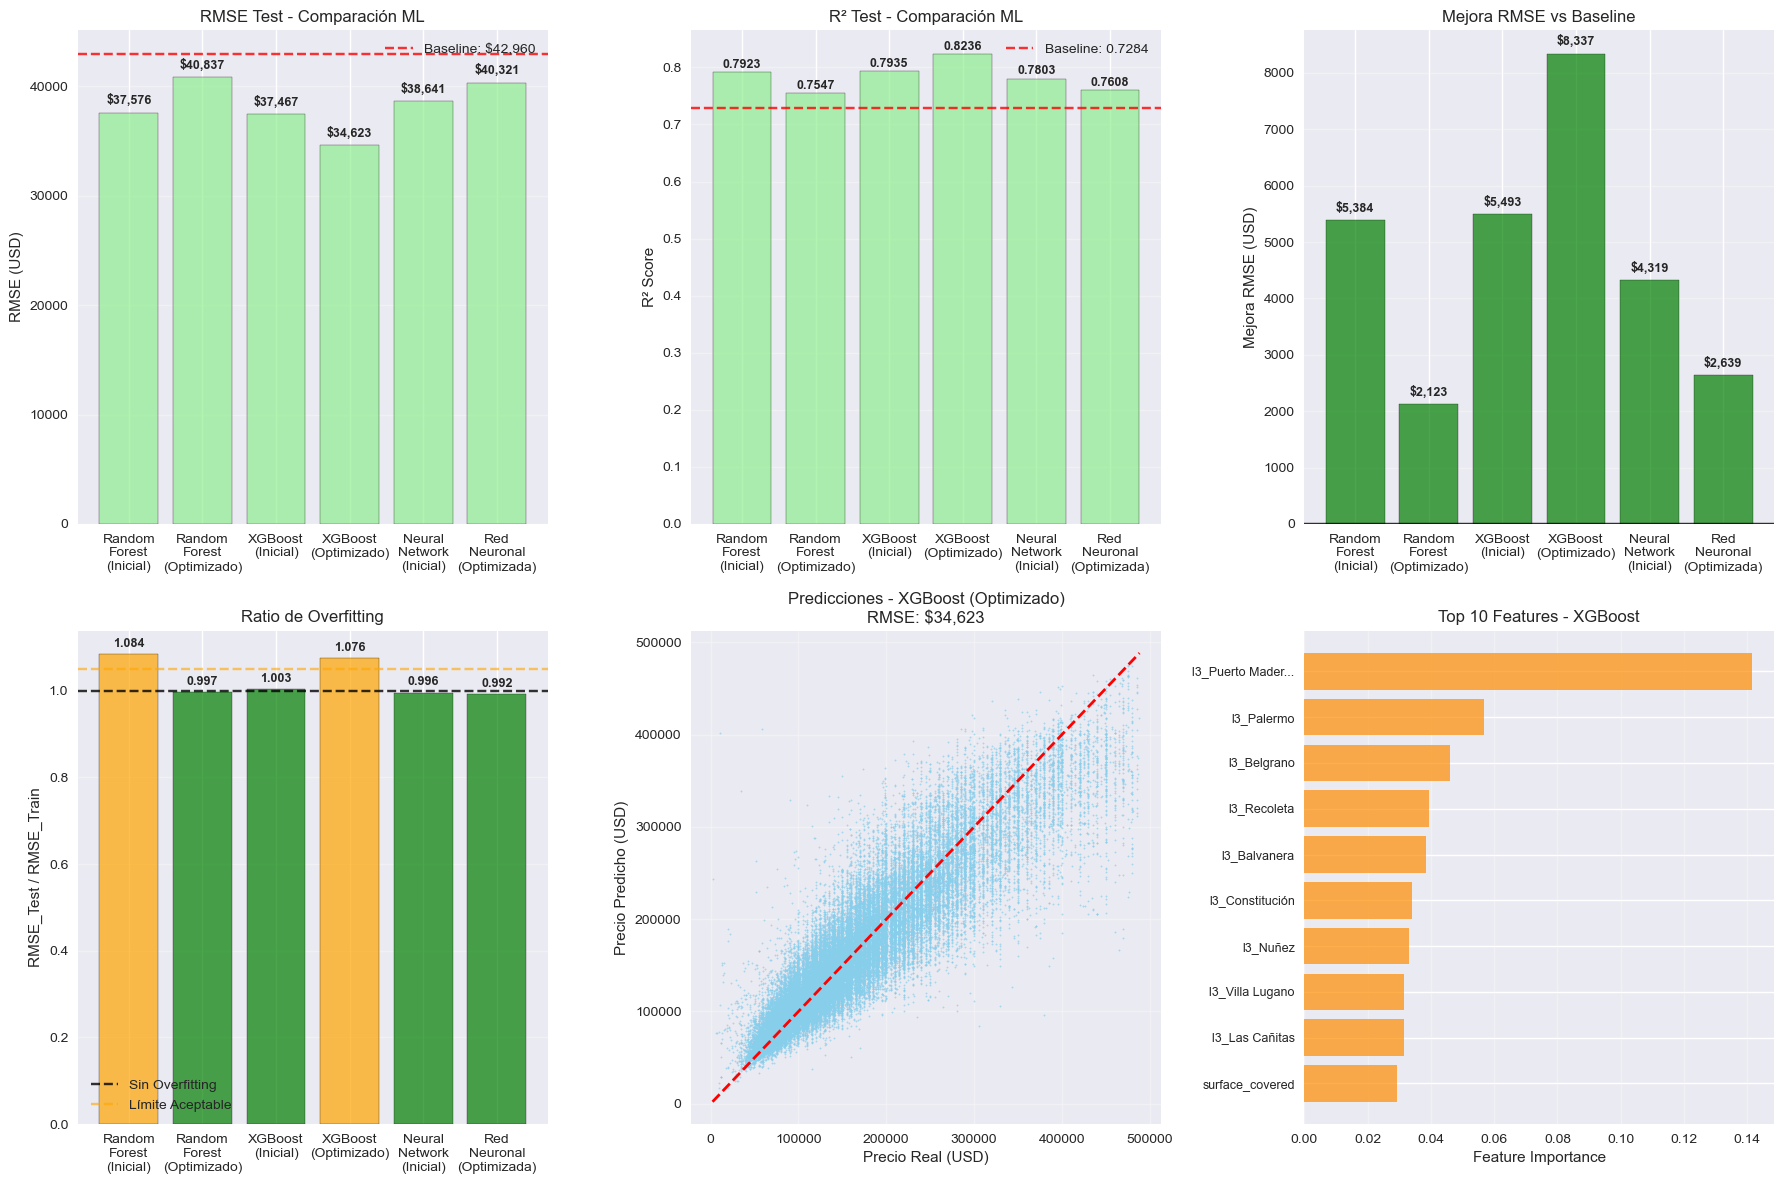


📋 RESUMEN EJECUTIVO - MODELOS ML AVANZADOS
🏆 ÉXITO: Modelos ML superan baseline tradicional
   • Mejor modelo: XGBoost (Optimizado)
   • Mejora RMSE: $8,337 (19.41%)
   • Nuevo RMSE: $34,623
   • Nuevo R²:   0.8236 (vs 0.7284)

📊 ESTADÍSTICAS GENERALES:
   • Modelos evaluados: 6
   • Modelos que superan baseline: 6
   • Tasa de éxito: 100.0%


In [22]:
# Visualizaciones comparativas completas
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. RMSE Comparación
models = comparison_df_ml['Modelo']
rmse_values = comparison_df_ml['RMSE_Test']
colors = ['lightcoral' if not x else 'lightgreen' for x in comparison_df_ml['Better_than_Baseline']]

bars1 = axes[0,0].bar(range(len(models)), rmse_values, color=colors, alpha=0.7, edgecolor='black')
axes[0,0].axhline(y=BASELINE_RMSE, color='red', linestyle='--', alpha=0.8, label=f'Baseline: ${BASELINE_RMSE:,}')
axes[0,0].set_title('RMSE Test - Comparación ML')
axes[0,0].set_ylabel('RMSE (USD)')
axes[0,0].set_xticks(range(len(models)))
axes[0,0].set_xticklabels([m.replace(' ', '\n') for m in models], rotation=0, ha='center')
axes[0,0].legend()
axes[0,0].grid(axis='y', alpha=0.3)

for i, v in enumerate(rmse_values):
    axes[0,0].text(i, v + 500, f'${v:,.0f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 2. R² Comparación
r2_values = comparison_df_ml['R2_Test']
bars2 = axes[0,1].bar(range(len(models)), r2_values, color=colors, alpha=0.7, edgecolor='black')
axes[0,1].axhline(y=BASELINE_R2, color='red', linestyle='--', alpha=0.8, label=f'Baseline: {BASELINE_R2:.4f}')
axes[0,1].set_title('R² Test - Comparación ML')
axes[0,1].set_ylabel('R² Score')
axes[0,1].set_xticks(range(len(models)))
axes[0,1].set_xticklabels([m.replace(' ', '\n') for m in models], rotation=0, ha='center')
axes[0,1].legend()
axes[0,1].grid(axis='y', alpha=0.3)

for i, v in enumerate(r2_values):
    axes[0,1].text(i, v + 0.002, f'{v:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 3. Mejora sobre Baseline
improvements = comparison_df_ml['RMSE_Improvement']
colors_improvement = ['red' if x < 0 else 'green' for x in improvements]
bars3 = axes[0,2].bar(range(len(models)), improvements, color=colors_improvement, alpha=0.7, edgecolor='black')
axes[0,2].axhline(y=0, color='black', linestyle='-', alpha=0.8)
axes[0,2].set_title('Mejora RMSE vs Baseline')
axes[0,2].set_ylabel('Mejora RMSE (USD)')
axes[0,2].set_xticks(range(len(models)))
axes[0,2].set_xticklabels([m.replace(' ', '\n') for m in models], rotation=0, ha='center')
axes[0,2].grid(axis='y', alpha=0.3)

for i, v in enumerate(improvements):
    axes[0,2].text(i, v + (100 if v >= 0 else -100), f'${v:,.0f}', ha='center', 
                   va='bottom' if v >= 0 else 'top', fontsize=9, fontweight='bold')

# 4. Overfitting Ratio
overfitting_ratios = comparison_df_ml['Overfitting_Ratio']
colors_overfitting = ['green' if x < 1.05 else 'orange' if x < 1.15 else 'red' for x in overfitting_ratios]
bars4 = axes[1,0].bar(range(len(models)), overfitting_ratios, color=colors_overfitting, alpha=0.7, edgecolor='black')
axes[1,0].axhline(y=1.0, color='black', linestyle='--', alpha=0.8, label='Sin Overfitting')
axes[1,0].axhline(y=1.05, color='orange', linestyle='--', alpha=0.6, label='Límite Aceptable')
axes[1,0].set_title('Ratio de Overfitting')
axes[1,0].set_ylabel('RMSE_Test / RMSE_Train')
axes[1,0].set_xticks(range(len(models)))
axes[1,0].set_xticklabels([m.replace(' ', '\n') for m in models], rotation=0, ha='center')
axes[1,0].legend()
axes[1,0].grid(axis='y', alpha=0.3)

for i, v in enumerate(overfitting_ratios):
    axes[1,0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 5. Predicciones del mejor modelo
if 'XGB' in best_model_name:
    y_pred_best = y_pred_test_xgb_best
elif 'Random Forest' in best_model_name:
    y_pred_best = y_pred_test_rf_best
else:
    y_pred_best = y_pred_test_nn_best

axes[1,1].scatter(y_test, y_pred_best, alpha=0.6, s=1, color='skyblue')
axes[1,1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1,1].set_xlabel('Precio Real (USD)')
axes[1,1].set_ylabel('Precio Predicho (USD)')
axes[1,1].set_title(f'Predicciones - {best_model_name}\nRMSE: ${best_rmse:,.0f}')
axes[1,1].grid(alpha=0.3)

# 6. Feature Importance (mejor modelo tree-based)
if 'Random Forest' in best_model_name:
    feature_imp = feature_importance_rf.head(10)
    axes[1,2].barh(range(len(feature_imp)), feature_imp['Importance'], color='forestgreen', alpha=0.7)
    axes[1,2].set_yticks(range(len(feature_imp)))
    axes[1,2].set_yticklabels([f[:15] + '...' if len(f) > 15 else f for f in feature_imp['Variable']], fontsize=9)
    axes[1,2].set_xlabel('Feature Importance')
    axes[1,2].set_title('Top 10 Features - Random Forest')
    axes[1,2].grid(axis='x', alpha=0.3)
    axes[1,2].invert_yaxis()
elif 'XGB' in best_model_name:
    xgb_importance_best = pd.DataFrame({
        'Variable': X.columns,
        'Importance': xgb_best.feature_importances_
    }).sort_values('Importance', ascending=False).head(10)
    
    axes[1,2].barh(range(len(xgb_importance_best)), xgb_importance_best['Importance'], color='darkorange', alpha=0.7)
    axes[1,2].set_yticks(range(len(xgb_importance_best)))
    axes[1,2].set_yticklabels([f[:15] + '...' if len(f) > 15 else f for f in xgb_importance_best['Variable']], fontsize=9)
    axes[1,2].set_xlabel('Feature Importance')
    axes[1,2].set_title('Top 10 Features - XGBoost')
    axes[1,2].grid(axis='x', alpha=0.3)
    axes[1,2].invert_yaxis()
else:
    axes[1,2].text(0.5, 0.5, 'Neural Networks\nno generan\nfeature importance\nexplícito', 
                   ha='center', va='center', transform=axes[1,2].transAxes, fontsize=12)
    axes[1,2].set_title('Feature Importance - No Disponible')

plt.tight_layout()
plt.show()

# Resumen ejecutivo final
print(f"\n📋 RESUMEN EJECUTIVO - MODELOS ML AVANZADOS")
print("=" * 75)

if best_improvement > 0:
    print(f"🏆 ÉXITO: Modelos ML superan baseline tradicional")
    print(f"   • Mejor modelo: {best_model_name}")
    print(f"   • Mejora RMSE: ${best_improvement:,.0f} ({best_improvement/BASELINE_RMSE*100:.2f}%)")
    print(f"   • Nuevo RMSE: ${best_rmse:,.0f}")
    print(f"   • Nuevo R²:   {best_r2:.4f} (vs {BASELINE_R2:.4f})")
else:
    print(f"⚠️ RESULTADO: Modelos tradicionales mantienen liderazgo")
    print(f"   • Mejor ML: {best_model_name}")
    print(f"   • Diferencia: ${abs(best_improvement):,.0f} peor que baseline")
    print(f"   • Baseline sigue siendo superior")

models_successful = len(models_better)
print(f"\n📊 ESTADÍSTICAS GENERALES:")
print(f"   • Modelos evaluados: {len(comparison_df_ml)}")
print(f"   • Modelos que superan baseline: {models_successful}")
print(f"   • Tasa de éxito: {models_successful/len(comparison_df_ml)*100:.1f}%")
